In [ ]:
# Step 1: Install Kaggle
!pip install kaggle -q

# Step 2: Upload your Kaggle API token (No longer needed if dataset is in Drive)
# from google.colab import files
# print("Upload your kaggle.json file:")
# uploaded = files.upload()

# Step 3: Setup Kaggle credentials (No longer needed if dataset is in Drive)
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# Step 4: Download DEAM dataset (No longer needed if dataset is in Drive)
# !kaggle datasets download -d imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music

# Step 5: Unzip (No longer needed if dataset is in Drive)
# !unzip deam-mediaeval-dataset-emotional-analysis-in-music.zip -d deam_dataset

# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Upload your kaggle.json file:


Streaming output truncated to the last 5000 lines.
  inflating: deam_dataset/DEAM_Annotations/annotations/annotations per each rater/dynamic (per second annotations)/valence/137.csv  
  inflating: deam_dataset/DEAM_Annotations/annotations/annotations per each rater/dynamic (per second annotations)/valence/1370.csv  
  inflating: deam_dataset/DEAM_Annotations/annotations/annotations per each rater/dynamic (per second annotations)/valence/1371.csv  
  inflating: deam_dataset/DEAM_Annotations/annotations/annotations per each rater/dynamic (per second annotations)/valence/1372.csv  
  inflating: deam_dataset/DEAM_Annotations/annotations/annotations per each rater/dynamic (per second annotations)/valence/1373.csv  
  inflating: deam_dataset/DEAM_Annotations/annotations/annotations per each rater/dynamic (per second annotations)/valence/1374.csv  
  inflating: deam_dataset/DEAM_Annotations/annotations/annotations per each rater/dynamic (per second annotations)/valence/1375.csv  
  inflating:

In [ ]:
# ===== 2. Load the DEAM Annotation Files =====
import pandas as pd
import numpy as np
import glob
import os

# Path to annotation files - UPDATED PATH
annotation_path = "/content/drive/MyDrive/CS 5100 FAI Final Project/deam_dataset/DEAM_Annotations/annotations/annotations per each rater/song_level/"

# Get all CSV files
annotation_files = sorted(glob.glob(f"{annotation_path}*.csv"))

print(f"Found {len(annotation_files)} annotation files")

# Load and combine all annotation files
all_annotations_standardized = []

for file in annotation_files:
    df = pd.read_csv(file)
    print(f"Loaded: {file} - {len(df)} songs")

    # Standardize column names
    # Check for ' SongId' or 'SongId' and rename to 'song_id'
    if ' SongId' in df.columns:
        df.rename(columns={' SongId': 'song_id'}, inplace=True)
    elif 'SongId' in df.columns:
        df.rename(columns={'SongId': 'song_id'}, inplace=True)
    # Important: Remove leading/trailing spaces from all column names after initial rename
    df.columns = df.columns.str.strip()

    # Determine which valence/arousal columns exist and rename to 'valence' and 'arousal'
    if 'Valence' in df.columns and 'Arousal' in df.columns:
        df.rename(columns={'Valence': 'valence', 'Arousal': 'arousal'}, inplace=True)
    elif 'Valence_Average' in df.columns and 'Arousal_Average' in df.columns:
        df.rename(columns={'Valence_Average': 'valence', 'Arousal_Average': 'arousal'}, inplace=True)
    else:
        # Handle cases where expected columns are not found
        print(f"Warning: Valence/Arousal columns not found in expected formats in {file}")
        continue # Skip this file if it doesn't have the required columns

    # Select only the relevant columns for aggregation
    # Ensure 'song_id', 'valence', 'arousal' are present before adding
    if 'song_id' in df.columns and 'valence' in df.columns and 'arousal' in df.columns:
        all_annotations_standardized.append(df[['song_id', 'valence', 'arousal']])
    else:
        print(f"Error: Missing 'song_id', 'valence', or 'arousal' after standardization for file {file}")


# Combine all processed annotations
if not all_annotations_standardized:
    # Added a more informative error message to guide debugging
    raise ValueError(f"No valid annotation files were processed after standardization. Checked path: {annotation_path}")
annotations_df = pd.concat(all_annotations_standardized, ignore_index=True)

print(f"\n{'='*50}")
print(f"Total annotations loaded: {len(annotations_df)}")
print(f"Columns: {annotations_df.columns.tolist()}")
print(f"\nFirst few rows:")
print(annotations_df.head())

# The annotations have multiple raters per song
# We need to aggregate (take mean) across raters

# Group by song_id and take mean
final_annotations = annotations_df.groupby('song_id').agg({
    'valence': 'mean',
    'arousal': 'mean'
}).reset_index()
final_annotations.columns = ['song_id', 'valence_mean', 'arousal_mean']

print(f"\n{'='*50}")
print(f"Unique songs with annotations: {len(final_annotations)}")
print(f"\nAnnotation statistics:")
print(f"Valence: {final_annotations['valence_mean'].min():.3f} to {final_annotations['valence_mean'].max():.3f}")
print(f"         Mean: {final_annotations['valence_mean'].mean():.3f}")
print(f"Arousal: {final_annotations['arousal_mean'].min():.3f} to {final_annotations['arousal_mean'].max():.3f}")
print(f"         Mean: {final_annotations['arousal_mean'].mean():.3f}")

# Define output directory
output_dir = '/content/drive/MyDrive/CS 5100 FAI Final Project'
output_filename = 'deam_processed_annotations.csv'
output_path = os.path.join(output_dir, output_filename)

# Create directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save processed annotations
final_annotations.to_csv(output_path, index=False)
print(f"\n✓ Saved to: {output_path}")


Found 2 annotation files
Loaded: /content/drive/MyDrive/CS 5100 FAI Final Project/deam_dataset/DEAM_Annotations/annotations/annotations per each rater/song_level/static_annotations_songs_1_2000.csv - 17464 songs
Loaded: /content/drive/MyDrive/CS 5100 FAI Final Project/deam_dataset/DEAM_Annotations/annotations/annotations per each rater/song_level/static_annotations_songs_2000_2058.csv - 298 songs

Total annotations loaded: 17762
Columns: ['song_id', 'valence', 'arousal']

First few rows:
   song_id  valence  arousal
0        2        5        2
1        2        2        3
2        2        3        3
3        2        4        4
4        2        2        2

Unique songs with annotations: 1802

Annotation statistics:
Valence: 1.600 to 8.400
         Mean: 4.904
Arousal: 1.600 to 8.100
         Mean: 4.814

✓ Saved to: /content/drive/MyDrive/CS 5100 FAI Final Project/deam_processed_annotations.csv


In [ ]:
# ===== 3. Verify that all DEAM Audio PY Files comes with annotion =====


import os
import pandas as pd

# Load annotations
annotations = pd.read_csv('/content/drive/MyDrive/CS 5100 FAI Final Project/deam_processed_annotations.csv')

# Audio path
audio_path = "/content/drive/MyDrive/CS 5100 FAI Final Project/deam_dataset/DEAM_audio/MEMD_audio/"

# Get all audio files
audio_files = [f for f in os.listdir(audio_path) if f.endswith('.mp3')]
audio_ids = [int(f.replace('.mp3', '')) for f in audio_files]

print(f"Audio files found: {len(audio_files)}")
print(f"Annotations found: {len(annotations)}")

# Match
annotations['has_audio'] = annotations['song_id'].isin(audio_ids)

matched = annotations[annotations['has_audio'] == True]
missing = annotations[annotations['has_audio'] == False]

print(f"\n{'='*50}")
print(f"Matched (audio + annotations): {len(matched)}")
print(f"Missing audio: {len(missing)}")

if len(missing) > 0:
    print(f"\nMissing song IDs: {missing['song_id'].tolist()}")

# Save matched songs for extraction
output_dir = '/content/drive/MyDrive/CS 5100 FAI Final Project'
output_filename = 'deam_final_dataset.csv'
output_path = os.path.join(output_dir, output_filename)

os.makedirs(output_dir, exist_ok=True)
matched.to_csv(output_path, index=False)

print(f"\n✓ Final dataset: {len(matched)} songs")
print(f"✓ Saved to: {output_path}")

Audio files found: 1802
Annotations found: 1802

Matched (audio + annotations): 1802
Missing audio: 0

✓ Final dataset: 1802 songs
✓ Saved to: /content/drive/MyDrive/CS 5100 FAI Final Project/deam_final_dataset.csv


In [ ]:
# ===== 4. Extract VGGish Features =====

import tensorflow_hub as hub
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm
import os

# Load final dataset - UPDATED PATH
dataset = pd.read_csv('/content/drive/MyDrive/CS 5100 FAI Final Project/deam_final_dataset.csv')
audio_path = "/content/drive/MyDrive/CS 5100 FAI Final Project/deam_dataset/DEAM_audio/MEMD_audio/" # Ensure this is also the correct path

# Load VGGish
print("Loading VGGish...")
vggish = hub.load('https://tfhub.dev/google/vggish/1')
print("✓ VGGish loaded!\n")

# Extract features
features_list = []
labels_list = []
song_ids_list = []
failed = []

print(f"Extracting features for {len(dataset)} songs...")
print("Expected time: 30-60 minutes\n")

for idx, row in tqdm(dataset.iterrows(), total=len(dataset)):
    song_id = row['song_id']
    audio_file = f"{audio_path}/{song_id}.mp3"

    try:
        # Load audio at 16kHz
        audio, sr = librosa.load(audio_file, sr=16000, mono=True)

        # Extract VGGish embeddings
        embeddings = vggish(audio).numpy()

        # Mean pooling
        features = np.mean(embeddings, axis=0)

        # Store
        features_list.append(features)
        labels_list.append([row['valence_mean'], row['arousal_mean']])
        song_ids_list.append(song_id)

    except Exception as e:
        print(f"\n✗ Failed: {song_id} - {e}")
        failed.append(song_id)
        continue

    # Checkpoint every 200 songs
    if (idx + 1) % 200 == 0:
        np.save('/content/drive/MyDrive/CS 5100 FAI Final Project/checkpoint_features.npy', np.array(features_list))
        np.save('/content/drive/MyDrive/CS 5100 FAI Final Project/checkpoint_labels.npy', np.array(labels_list))
        print(f"\n✓ Checkpoint: {len(features_list)} songs extracted")

# Convert to arrays
features_array = np.array(features_list)
labels_array = np.array(labels_list)
song_ids_array = np.array(song_ids_list)

print(f"\n{'='*50}")
print(f"Extraction Complete!")
print(f"Success: {len(features_array)}/{len(dataset)}")
print(f"Failed: {len(failed)}")
print(f"\nShapes:")
print(f"Features: {features_array.shape}")
print(f"Labels: {labels_array.shape}")
print(f"Song IDs: {song_ids_array.shape}")

# Save - UPDATED OUTPUT DIRECTORY
output_dir_processed = '/content/drive/MyDrive/CS 5100 FAI Final Project/deam_processed'
os.makedirs(output_dir_processed, exist_ok=True)

np.save(os.path.join(output_dir_processed, 'vggish_features.npy'), features_array)
np.save(os.path.join(output_dir_processed, 'labels.npy'), labels_array)
np.save(os.path.join(output_dir_processed, 'song_ids.npy'), song_ids_array)

if failed:
    pd.DataFrame({'song_id': failed}).to_csv(
        os.path.join(output_dir_processed, 'failed_songs.csv'), index=False
    )

print(f"\n✓ Saved to {output_dir_processed}/")


Loading VGGish...
✓ VGGish loaded!

Extracting features for 1802 songs...
Expected time: 30-60 minutes



 11%|█         | 200/1802 [04:06<29:55,  1.12s/it]


✓ Checkpoint: 200 songs extracted


 22%|██▏       | 400/1802 [07:40<21:15,  1.10it/s]


✓ Checkpoint: 400 songs extracted


 33%|███▎      | 600/1802 [11:28<23:22,  1.17s/it]


✓ Checkpoint: 600 songs extracted


 44%|████▍     | 800/1802 [15:14<21:49,  1.31s/it]


✓ Checkpoint: 800 songs extracted


 55%|█████▌    | 1000/1802 [19:07<14:56,  1.12s/it]


✓ Checkpoint: 1000 songs extracted


 67%|██████▋   | 1200/1802 [23:01<12:12,  1.22s/it]


✓ Checkpoint: 1200 songs extracted


 78%|███████▊  | 1400/1802 [27:00<08:03,  1.20s/it]


✓ Checkpoint: 1400 songs extracted


 89%|████████▉ | 1600/1802 [30:57<03:44,  1.11s/it]


✓ Checkpoint: 1600 songs extracted


100%|█████████▉| 1800/1802 [37:14<00:05,  2.89s/it]


✓ Checkpoint: 1800 songs extracted


100%|██████████| 1802/1802 [37:22<00:00,  1.24s/it]


Extraction Complete!
Success: 1802/1802
Failed: 0

Shapes:
Features: (1802, 128)
Labels: (1802, 2)
Song IDs: (1802,)

✓ Saved to /content/drive/MyDrive/CS 5100 FAI Final Project/deam_processed/


In [ ]:
# =====5. split_deam_features.py =====

from sklearn.model_selection import train_test_split
import numpy as np
import os

# Define the base directory for processed files
processed_dir = '/content/drive/MyDrive/CS 5100 FAI Final Project/deam_processed'

# Load extracted features - UPDATED PATHS
features = np.load(os.path.join(processed_dir, 'vggish_features.npy'))
labels = np.load(os.path.join(processed_dir, 'labels.npy'))
song_ids = np.load(os.path.join(processed_dir, 'song_ids.npy'))

total_songs = len(features)
print(f"Total songs: {total_songs}")

# ================================================
# SPLIT 1: Separate 70% for training
# ================================================
X_train, X_temp, y_train, y_temp, ids_train, ids_temp = train_test_split(
    features,
    labels,
    song_ids,
    test_size=0.30,      # ← 30% goes to temp (NOT sample size!)
    random_state=42,     # ← Seed for reproducibility (NOT sample size!)
    shuffle=True
)

print(f"\n{'='*50}")
print(f"After Split 1:")
print(f"Train: {len(X_train)} songs ({len(X_train)/total_songs*100:.1f}%)")
print(f"Temp:  {len(X_temp)} songs ({len(X_temp)/total_songs*100:.1f}%)")

# ================================================
# SPLIT 2: Split temp into 15% val + 15% test
# ================================================
X_val, X_test, y_val, y_test, ids_val, ids_test = train_test_split(
    X_temp,
    y_temp,
    ids_temp,
    test_size=0.50,      # ← 50% of temp = 15% of original
    random_state=42
)

print(f"\nAfter Split 2:")
print(f"Val:  {len(X_val)} songs ({len(X_val)/total_songs*100:.1f}%)")
print(f"Test: {len(X_test)} songs ({len(X_test)/total_songs*100:.1f}%)")

# ================================================
# VERIFY: Check the final split is 70/15/15
# ================================================
print(f"\n{'='*50}")
print(f"FINAL SPLIT:")
print(f"Train: {len(X_train):4d} songs ({len(X_train)/total_songs*100:.1f}%)")
print(f"Val:   {len(X_val):4d} songs ({len(X_val)/total_songs*100:.1f}%)")
print(f"Test:  {len(X_test):4d} songs ({len(X_test)/total_songs*100:.1f}%)")
print(f"Total: {len(X_train)+len(X_val)+len(X_test):4d} songs")

# Verify no overlap
assert len(set(ids_train) & set(ids_val)) == 0, "ERROR: Train-Val overlap!"
assert len(set(ids_train) & set(ids_test)) == 0, "ERROR: Train-Test overlap!"
assert len(set(ids_val) & set(ids_test)) == 0, "ERROR: Val-Test overlap!"
print(f"\n✓ No overlap between splits verified!")

# Save splits - UPDATED PATH
save_dir = os.path.join(processed_dir, 'splits/')
os.makedirs(save_dir, exist_ok=True)

np.save(f'{save_dir}/X_train.npy', X_train)
np.save(f'{save_dir}/y_train.npy', y_train)
np.save(f'{save_dir}/ids_train.npy', ids_train)

np.save(f'{save_dir}/X_val.npy', X_val)
np.save(f'{save_dir}/y_val.npy', y_val)
np.save(f'{save_dir}/ids_val.npy', ids_val)

np.save(f'{save_dir}/X_test.npy', X_test)
np.save(f'{save_dir}/y_test.npy', y_test)
np.save(f'{save_dir}/ids_test.npy', ids_test)

print(f"\n✓ All splits saved to: {save_dir}")

Total songs: 1802

After Split 1:
Train: 1261 songs (70.0%)
Temp:  541 songs (30.0%)

After Split 2:
Val:  270 songs (15.0%)
Test: 271 songs (15.0%)

FINAL SPLIT:
Train: 1261 songs (70.0%)
Val:    270 songs (15.0%)
Test:   271 songs (15.0%)
Total: 1802 songs

✓ No overlap between splits verified!

✓ All splits saved to: /content/drive/MyDrive/CS 5100 FAI Final Project/deam_processed/splits/


Using device: cuda

Loading data...
Train: 1261 samples, shape: (1261, 128)
Val:   270 samples, shape: (270, 128)

Model architecture:
AudioOnlyBaseline(
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=32, out_features=2, bias=True)
)

Total parameters: 10,402

Starting Training...

Epoch   1/100 | Train Loss: 16.8838 | Val Loss: 2.0643 | R_val: 0.297 | R_ar: 0.257
  → Saved best model (val_loss: 2.0643)
Epoch   2/100 | Train Loss: 2.7510 | Val Loss: 1.0889 | R_val: 0.576 | R_ar: 0.619
  → Saved best model (val_loss: 1.0889)
Epoch   3/100 | Train Loss: 2.1486 | Val Loss: 0.8354 | R_val: 0.625 | R_ar: 0.686
  → Saved best model (val_loss: 0.8354)
Epoch   4/100 | Train Loss: 1.9149 | Val Loss: 0.8392 | R_val: 0.656 | R_ar: 0.715
Epoch   5/100 | Train Loss: 1.7532 | Val Loss: 0.8091 | R_val: 0.673 | 

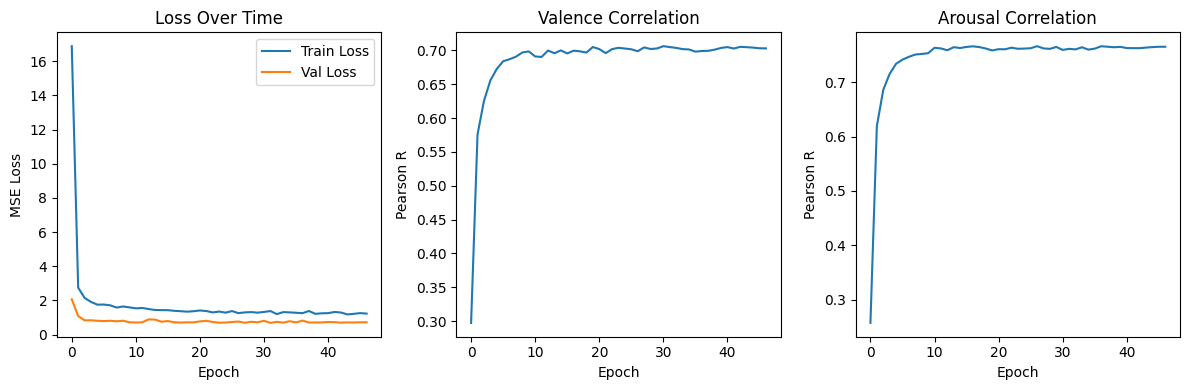

In [ ]:
# ===== train_audio_baseline.py =====

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import os # Import os module to handle paths

# ============================================
# 1. DATASET CLASS
# ============================================

class AudioDataset(Dataset):
    """Dataset for VGGish features and V-A labels"""

    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# ============================================
# 2. MODEL ARCHITECTURE
# ============================================

class AudioOnlyBaseline(nn.Module):
    """
    Simple regression model for V-A prediction from VGGish features

    Architecture:
    Input (128) → FC1 (64) → ReLU → Dropout
                → FC2 (32) → ReLU → Dropout
                → Output (2: valence, arousal)
    """

    def __init__(self, input_dim=128, hidden_dim1=64, hidden_dim2=32, dropout=0.3):
        super(AudioOnlyBaseline, self).__init__()

        # Layer 1: 128 → 64
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(dropout)

        # Layer 2: 64 → 32
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout2 = nn.Dropout(dropout)

        # Output layer: 32 → 2 (valence, arousal)
        self.output = nn.Linear(hidden_dim2, 2)

    def forward(self, x):
        # x shape: (batch_size, 128)

        # Layer 1
        x = self.fc1(x)           # (batch_size, 64)
        x = torch.relu(x)         # ReLU activation
        x = self.dropout1(x)      # Dropout

        # Layer 2
        x = self.fc2(x)           # (batch_size, 32)
        x = torch.relu(x)
        x = self.dropout2(x)

        # Output (NO activation - raw regression values)
        x = self.output(x)        # (batch_size, 2)

        return x  # [valence, arousal]

# ============================================
# 3. TRAINING FUNCTION
# ============================================

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0

    for features, labels in train_loader:
        features = features.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        predictions = model(features)

        # Compute loss
        loss = criterion(predictions, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

# ============================================
# 4. EVALUATION FUNCTION
# ============================================

def evaluate(model, data_loader, criterion, device):
    """Evaluate model on validation/test set"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels in data_loader:
            features = features.to(device)
            labels = labels.to(device)

            # Predictions
            predictions = model(features)

            # Loss
            loss = criterion(predictions, labels)
            total_loss += loss.item()

            # Store for correlation calculation
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate all batches
    all_preds = np.vstack(all_preds)    # (N, 2)
    all_labels = np.vstack(all_labels)  # (N, 2)

    # Calculate Pearson correlation for valence and arousal
    r_valence, _ = pearsonr(all_preds[:, 0], all_labels[:, 0])
    r_arousal, _ = pearsonr(all_preds[:, 1], all_labels[:, 1])

    avg_loss = total_loss / len(data_loader)

    return avg_loss, r_valence, r_arousal

# ============================================
# 5. MAIN TRAINING SCRIPT
# ============================================

def main():
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")

    # ============================================
    # Load Data
    # ============================================
    print("Loading data...")

    # Define the base directory for processed files
    processed_dir = '/content/drive/MyDrive/CS 5100 FAI Final Project/deam_processed'
    splits_dir = os.path.join(processed_dir, 'splits')

    X_train = np.load(os.path.join(splits_dir, 'X_train.npy'))
    y_train = np.load(os.path.join(splits_dir, 'y_train.npy'))

    X_val = np.load(os.path.join(splits_dir, 'X_val.npy'))
    y_val = np.load(os.path.join(splits_dir, 'y_val.npy'))

    # DON'T load test set yet!
    # X_test = np.load(os.path.join(splits_dir, 'X_test.npy'))
    # y_test = np.load(os.path.join(splits_dir, 'y_test.npy'))

    print(f"Train: {len(X_train)} samples, shape: {X_train.shape}")
    print(f"Val:   {len(X_val)} samples, shape: {X_val.shape}")

    # ============================================
    # Create Datasets and DataLoaders
    # ============================================

    train_dataset = AudioDataset(X_train, y_train)
    val_dataset = AudioDataset(X_val, y_val)

    train_loader = DataLoader(
        train_dataset,
        batch_size=32,      # 32 samples per batch
        shuffle=True,       # Shuffle training data
        num_workers=0       # 0 for Colab, 2-4 for local
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,      # Don't shuffle validation
        num_workers=0
    )

    # ============================================
    # Initialize Model
    # ============================================

    model = AudioOnlyBaseline(
        input_dim=128,
        hidden_dim1=64,
        hidden_dim2=32,
        dropout=0.3
    ).to(device)

    print(f"\nModel architecture:")
    print(model)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\nTotal parameters: {total_params:,}")

    # ============================================
    # Loss and Optimizer
    # ============================================

    criterion = nn.MSELoss()  # Mean Squared Error for regression

    optimizer = optim.Adam(
        model.parameters(),
        lr=0.001,           # Learning rate
        weight_decay=1e-4   # L2 regularization
    )

    # Learning rate scheduler (optional but helpful)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5
    )

    # ============================================
    # Training Loop
    # ============================================

    num_epochs = 100
    best_val_loss = float('inf')
    patience = 15
    patience_counter = 0

    train_losses = []
    val_losses = []
    val_r_valences = []
    val_r_arousals = []

    print(f"\n{'='*50}")
    print(f"Starting Training...")
    print(f"{'='*50}\n")

    for epoch in range(num_epochs):
        # Train
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, r_valence, r_arousal = evaluate(model, val_loader, criterion, device)

        # Store history
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_r_valences.append(r_valence)
        val_r_arousals.append(r_arousal)

        # Print progress
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"R_val: {r_valence:.3f} | "
              f"R_ar: {r_arousal:.3f}")

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Save best model
        # Ensure the directory for saving the model exists
        model_save_dir = os.path.join(processed_dir)
        os.makedirs(model_save_dir, exist_ok=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(model_save_dir, 'best_model.pth'))
            patience_counter = 0
            print(f"  → Saved best model (val_loss: {val_loss:.4f})")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

    # ============================================
    # Final Evaluation
    # ============================================

    print(f"\n{'='*50}")
    print(f"Training Complete!")
    print(f"{'='*50}")

    # Load best model
    model.load_state_dict(torch.load(os.path.join(processed_dir, 'best_model.pth')))

    # Final validation results
    val_loss, r_valence, r_arousal = evaluate(model, val_loader, criterion, device)

    print(f"\nBest Model Performance (Validation Set):")
    print(f"Loss:          {val_loss:.4f}")
    print(f"R_valence:     {r_valence:.3f}")
    print(f"R_arousal:     {r_arousal:.3f}")
    print(f"R_mean:        {(r_valence + r_arousal)/2:.3f}")

    # ============================================
    # Plot Training History
    # ============================================

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title('Loss Over Time')

    plt.subplot(1, 3, 2)
    plt.plot(val_r_valences)
    plt.xlabel('Epoch')
    plt.ylabel('Pearson R')
    plt.title('Valence Correlation')

    plt.subplot(1, 3, 3)
    plt.plot(val_r_arousals)
    plt.xlabel('Epoch')
    plt.ylabel('Pearson R')
    plt.title('Arousal Correlation')

    plt.tight_layout()
    # Save plot to the specified processed directory
    plot_save_path = os.path.join(processed_dir, 'training_history.png')
    plt.savefig(plot_save_path, dpi=150)
    print(f"\n✓ Saved training plot to: {plot_save_path}")

    return model

# ============================================
# RUN TRAINING
# ============================================

if __name__ == "__main__":
    model = main()
